# Исследование надежности заемщиков.

**Цель исследования** - ответить на вопросы:
1. Есть ли зависимость между количеством детей и возвратом кредита в срок?
2. Есть ли зависимость между семейным положением и возвратом кредита в срок?
3. Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
4. Как разные цели кредита влияют на его возврат в срок?


## Шаг Обзор данных

In [83]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [84]:
data = pd.read_csv('/datasets/data.csv') 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [85]:
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


**Вывод**:
1. В двух столбцах "days_employed" и "total_income" есть пропуски в данных
2. В столбце "days_employed" отрицательные значения
3. В столбце "education" дубликаты

## Шаг Предобработка данных

### Шаг Заполнение пропусков

In [86]:
data.isna().sum() # поиск пропусков по столбцам

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

При обзоре данных, в столбце "total_income" найдены пропуски.
Смотрим их количество и долю от общего числа значений.

In [88]:
pd.DataFrame(round((data.isna().mean()*100),2), columns=['NaNs, %']).style.format(
    '{:.2f}').background_gradient('coolwarm')

,"NaNs, %"
children,0.00
days_employed,10.10
dob_years,0.00
education,0.00
education_id,0.00
family_status,0.00
family_status_id,0.00
gender,0.00
income_type,0.00
debt,0.00


Доля пропусков - чуть больше 10%.
Столбец содержит количественные значения, заполняю пропуски медианным значением.

In [90]:
for unic_type in data['income_type'].unique(): # заменю нулевые значени, на медианные по типу занятости 
    median_type = data[(data['income_type'] == unic_type)]['total_income'].median()
    data.loc[(data['income_type'] == unic_type), 'total_income'] = data.loc[(data['income_type'] == unic_type), 'total_income'].fillna(median_type)

### Шаг Проверка данных на аномалии и исправления.

При обзоре данных, в столбце "days_employed" найдены отрицательные значения. Считаю их кол-во и хочу посмотреть первые 10 строк, возможно удасться восстановить закономерность.

In [91]:
data.loc[data['days_employed'] < 0, 'days_employed'].count()
data.loc[data['days_employed'] < 0].head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи
10,2,-4171.483647,36,высшее,0,женат / замужем,0,M,компаньон,0,113943.491460,покупка недвижимости


Предполагаю, что появление отрицательных значений - какая-то техничекая ошибка. Заменяю все значения на положительные.
Также в столбце присутствуют пропуски. Считаю их кол-во и долю от общего числа.

In [92]:
data['days_employed'] = data['days_employed'].abs() # меняю отрицательные значения
len(data[data['days_employed'].isna()]) # проверка на пропуски в столбце 'days_employed'
len(data[data['days_employed'].isna()]) / len(data['days_employed']) #считаю долю пропусков от общего числа значений

0.10099883855981417

Доля пропусков - чуть больше 10%. Столбец содержит количественные значения, заполняю медианным значением с учётом возраста заёмщика. Для этого сначала проверяю столбец 'dob_years' на нулевые значения и аномалии.

In [93]:
pd.set_option('float_format', '{:f}'.format)
data.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,21525.000000,19351.000000,21525.000000,21525.000000,21525.000000,21525.000000,21525.000000
mean,0.538908,66914.728907,43.293380,0.817236,0.972544,0.080883,165225.324514
std,1.381587,139030.880527,12.574584,0.548138,1.420324,0.272661,98043.665491
min,-1.000000,24.141633,0.000000,0.000000,0.000000,0.000000,20667.263793
25%,0.000000,927.009265,33.000000,1.000000,0.000000,0.000000,107798.172619
50%,0.000000,2194.220567,42.000000,1.000000,0.000000,0.000000,142594.396847
75%,1.000000,5537.882441,53.000000,1.000000,1.000000,0.000000,195549.940861
max,20.000000,401755.400475,75.000000,4.000000,4.000000,1.000000,2265604.028723


<AxesSubplot:>

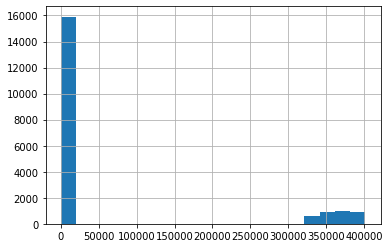

In [94]:
data['days_employed'].hist(bins = 20)

In [95]:
len(data.loc[data['days_employed'] > 300000]) # считаю, сколько таких значений в таблице

3445

Предполагаю, что при внесении данных, значения были проставлены в часах, а не в днях. Корректирую.

In [96]:
data.loc[(data['days_employed'] >= 300000), 'days_employed'] = data.loc[(data['days_employed'] >= 300000), 'days_employed'] / 24

In [97]:
data['dob_years'].isna().sum()
data['dob_years'].value_counts() # проверка значений столбца 'dob_years'

35    617
40    609
41    607
34    603
38    598
42    597
33    581
39    573
31    560
36    555
44    547
29    545
30    540
48    538
37    537
50    514
43    513
32    510
49    508
28    503
45    497
27    493
56    487
52    484
47    480
54    479
46    475
58    461
57    460
53    459
51    448
59    444
55    443
26    408
60    377
25    357
61    355
62    352
63    269
64    265
24    264
23    254
65    194
66    183
22    183
67    167
21    111
0     101
68     99
69     85
70     65
71     58
20     51
72     33
19     14
73      8
74      6
75      1
Name: dob_years, dtype: int64

У 101 клиента банка возраст указан 0. Скорее всего данные не были заполнены.
В конкретном случае выделю таких заёмщиков в отдельную категорию. 
Чтобы заполнить пропуски в days_employed, категоризирую столбец возраста.
Затем заполняю пропуски медианными значениям, с учётом возрастной группы.

In [99]:
def age_group (age): #создаю функцию для категоризации возраста заёмщика
    if age == 0:
        return 'unknowen'
    if 18 <= age <= 29:
        return '18+'
    if 30 <= age <= 39:
        return '30+'
    if 40 <= age <= 49:
        return '40+'
    if 50 <= age <= 59:
        return '50+'
    if  age >= 60:
        return '60+'

data['age_category'] = data['dob_years'].apply(age_group) # добавляю столбец с категориями по возрасту
data.groupby('age_category')['days_employed'].apply(lambda data: data.isna().sum()) # проверяю, для каких возрастных групп отсутствуют данные о трудовом стаже

age_category
18+         299
30+         565
40+         537
50+         501
60+         262
unknowen     10
Name: days_employed, dtype: int64

In [100]:
for unic_age_category in data['age_category'].unique(): # заменю нулевые значени на медианные по категории возраста 
    median_type = data[(data['age_category'] == unic_age_category)]['days_employed'].median()
    data.loc[(data['age_category'] == unic_age_category), 'days_employed'] = data.loc[(data['age_category'] == unic_age_category), 'days_employed'].fillna(median_type)

### Шаг Изменение типов данных.

In [101]:
data['total_income'] = data ['total_income'].astype('int') #замена типа данных на целочисленное значение
data['total_income'].dtypes

dtype('int64')

In [102]:
data['days_employed'] = data ['days_employed'].astype('int') #замена типа данных на целочисленное значение
data['days_employed'].dtypes

dtype('int64')

### Шаг Удаление дубликатов.

При обзоре данных, в столбце "education" найдены дубликаты. Методом value_counts() смотрю все уникальные значения и частоту их использования

In [103]:
data['education'].value_counts() # проверяю уникальные значение в столбце 'education'

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

Значения в столбце отличаются только регистром букв. Привожу их к одинаковым значениям методом .str.lower()

In [104]:
data['education'] = data['education'].str.lower() #устраняю неявные дубликаты в столбце 'education'

### Шаг Проверка данных в остальных столбцах

In [105]:
data['children'].value_counts() #проверка данных в столбце 'children'

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

В столбце 'children' найдены две аномалии: отрицательные значения и сомнительные 20 детей у 76 заёмщиков. 
В первом случае, предположительно, ошибка при выгрузке данных и значение можно заменить на положительное.
Во втором случае возможно ошибка внесения данных: так как в статистике нет ни одного клиента банка с кол-вом детей от 6 и до 19. А 20 детей есть сразу у 76 человек. Если имело место опечатка - нет уверенности, хотел ли человек внести 2 или 0 детей. Строки с аномалией составляют менее процента от общего числа. Предполагаю, что от них можно избавитья.

In [106]:
data.drop(data.loc[data['children'] == 20].index, inplace=True) #удаляю строку со странной аномалией
# data['children'] = data['children'].abs() # заменяю отрицательное значение на положительное

In [107]:
data.drop(data.loc[data['children'] == -1].index, inplace=True)

In [108]:
data['education_id'].value_counts() # проверка значений столбца 'education_id' 

1    15136
0     5237
2      741
3      282
4        6
Name: education_id, dtype: int64

In [109]:
data['family_status'].value_counts() # проверка значений столбца 'family_status'

женат / замужем          12302
гражданский брак          4160
Не женат / не замужем     2799
в разводе                 1189
вдовец / вдова             952
Name: family_status, dtype: int64

In [110]:
data['family_status_id'].value_counts() # проверка значений столбца 'family_status_id'

0    12302
1     4160
4     2799
3     1189
2      952
Name: family_status_id, dtype: int64

In [111]:
data['gender'].value_counts() # проверка значений столбца 'family_status_id'

F      14154
M       7247
XNA        1
Name: gender, dtype: int64

In [112]:
data.loc[data['gender'] == 'XNA'] # просматриваю строку с артефактом в поле гендер

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,age_category
10701,0,2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости,18+


Скорее всего ошибка в заполнении данных. По  сопутствующим в таблице данным запонить ячейку не удасться. Так как значения столбца пол не будут учавстовать в исследовании, значением можно пренебречь.

In [113]:
data['income_type'].value_counts() # проверка значений столбца 'income_type'

сотрудник          11050
компаньон           5054
пенсионер           3839
госслужащий         1453
предприниматель        2
безработный            2
студент                1
в декрете              1
Name: income_type, dtype: int64

In [114]:
data['debt'].value_counts() # проверка значений столбца 'debt'

0    19670
1     1732
Name: debt, dtype: int64

In [115]:
data['purpose'].value_counts() # проверка значений столбца 'purpose'

свадьба                                   796
на проведение свадьбы                     772
сыграть свадьбу                           769
операции с недвижимостью                  673
покупка коммерческой недвижимости         661
покупка жилья для сдачи                   651
операции с жильем                         648
операции с коммерческой недвижимостью     646
жилье                                     642
покупка жилья                             641
покупка жилья для семьи                   640
недвижимость                              632
строительство собственной недвижимости    628
операции со своей недвижимостью           626
строительство жилой недвижимости          622
строительство недвижимости                620
покупка своего жилья                      619
покупка недвижимости                      619
ремонт жилью                              609
покупка жилой недвижимости                603
на покупку своего автомобиля              504
заняться высшим образованием      

В столбце 'purpose' очень много скрытых дубликатов. Для этого столбца в следущих шагах будет сделана категоризация. Поэтому оставляем без изменений. 

In [116]:
data.duplicated().sum() #проверяю кол-во дубликатов в таблице

71

In [117]:
data = data.drop_duplicates().reset_index(drop = True) #удаляю дубликаты

<AxesSubplot:>

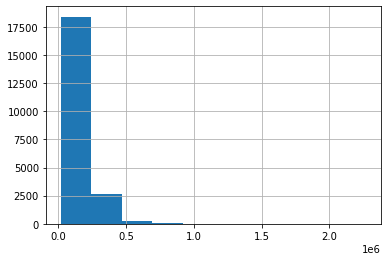

In [118]:
data['total_income'].hist(bins = 10)

### Шаг Формирование дополнительных датафреймов словарей, декомпозиция исходного датафрейма.

In [119]:
education_dict = data[['education', 'education_id']] # создаю отдельную таблицу для словаря значений образования
education_dict = education_dict.drop_duplicates().reset_index(drop=True) # удаляю дубликаты

In [120]:
family_status_dict = data[['family_status', 'family_status_id']] # создаю отдельную таблицу для словаря значений образования
family_status_dict = family_status_dict.drop_duplicates().reset_index(drop=True) # удаляю дубликаты

In [121]:
data.drop(["education", "family_status"], axis = 1, inplace = True) # удаляю столбцы
data.head(10)

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,age_category
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,40+
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,30+
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,30+
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,30+
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,50+
5,0,926,27,0,1,M,компаньон,0,255763,покупка жилья,18+
6,0,2879,43,0,0,F,компаньон,0,240525,операции с жильем,40+
7,0,152,50,1,0,M,сотрудник,0,135823,образование,50+
8,2,6929,35,0,1,F,сотрудник,0,95856,на проведение свадьбы,30+
9,0,2188,41,1,0,M,сотрудник,0,144425,покупка жилья для семьи,40+


### Шаг Категоризация дохода.

In [122]:
def total_income_group (income): #создаю функцию для категоризации доходов
    if 0 <= income <= 30000:
        return 'E'
    if 30001 <= income <= 50000:
        return 'D'
    if 50001 <= income <= 200000:
        return 'C'
    if 200001 <= income <= 1000000:
        return 'B'
    if  income >= 1000001:
        return 'A'

data['total_income_category'] = data['total_income'].apply(total_income_group) # добавляю столбец с категориями по доходу
data.head()

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,age_category,total_income_category
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,40+,B
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,30+,C
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,30+,C
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,30+,B
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,50+,C


### Шаг Категоризация целей кредита.

In [123]:
def purpose_cat (purpose): # создаю функцию, для присвоения категорий целям кредита
    if 'автомобил' in purpose :
        return 'операции с автомобилем'
    if 'недвижимост' in purpose or 'жиль' in purpose:
        return 'операции с недвижимостью'
    if 'свадьб' in purpose:
        return 'проведение свадьбы'
    if 'образован' in purpose:
        return 'получение образования'

data['purpose_category'] = data['purpose'].apply(purpose_cat) # добавляю столбец с категориями
data.head() 

,children,days_employed,dob_years,education_id,family_status_id,gender,income_type,debt,total_income,purpose,age_category,total_income_category,purpose_category
0,1,8437,42,0,0,F,сотрудник,0,253875,покупка жилья,40+,B,операции с недвижимостью
1,1,4024,36,1,0,F,сотрудник,0,112080,приобретение автомобиля,30+,C,операции с автомобилем
2,0,5623,33,1,0,M,сотрудник,0,145885,покупка жилья,30+,C,операции с недвижимостью
3,3,4124,32,1,0,M,сотрудник,0,267628,дополнительное образование,30+,B,получение образования
4,0,14177,53,1,1,F,пенсионер,0,158616,сыграть свадьбу,50+,C,проведение свадьбы


## Ответы на вопросы.

### Вопрос 1: Есть ли зависимость между количеством детей и возвратом кредита в срок?

В группах заёмщиков с 3 детьми и более, очень небольшая выборка. Их можно объеденить в одну группу многодетных.

In [126]:
def data_pivot(column_name): 
    return data.pivot_table(index = column_name, values = ['debt'], aggfunc = [len, sum, np.mean]).rename(columns = {'len': 'Всего кредитополучателей', 'sum': 'Количество должников', 'mean': 'Доля должников'}).reset_index()

In [127]:
data_pivot(column_name = ['children'])

,children,Всего кредитополучателей,Количество должников,Доля должников
,,debt,debt,debt
0,0,14091,1063,0.075438
1,1,4808,444,0.092346
2,2,2052,194,0.094542
3,3,330,27,0.081818
4,4,41,4,0.097561
5,5,9,0,0.000000


**Вывод 1:** заёмщики без детей берут больше кредитов и имеют меньше задолжностей. Больше всего задолжностей у родителей 4 детей, 2 и 1 ребёнка.

### Вопрос 2: Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [129]:
pivot_family_status = data_pivot(column_name = ['family_status_id'])
family_status_dict.merge(pivot_family_status, on = 'family_status_id', how='left')

,family_status,family_status_id,"(Всего кредитополучателей, debt)","(Количество должников, debt)","(Доля должников, debt)"
0,женат / замужем,0,12261,927,0.075606
1,гражданский брак,1,4134,385,0.093130
2,вдовец / вдова,2,951,63,0.066246
3,в разводе,3,1189,84,0.070648
4,Не женат / не замужем,4,2796,273,0.097639


**Вывод 2:** Больше всего задолжностей у никогда не состоявших в официальном браке

Рассмотрим доли должников в разрезе семейного статуса и кол-ва детей

In [130]:
data_pivot(column_name = ['family_status_id', 'children'])

,family_status_id,children,Всего кредитополучателей,Количество должников,Доля должников
,,,debt,debt,debt
0,0,0,7468,516,0.069095
1,0,1,2975,246,0.082689
2,0,2,1533,145,0.094586
3,0,3,249,17,0.068273
4,0,4,29,3,0.103448
5,0,5,7,0,0.000000
6,1,0,2730,229,0.083883
7,1,1,995,118,0.118593
8,1,2,343,30,0.087464


Практически во всех группах с увеличением кол-ва детей, увеличивается доля по задержкам выплаты кредита. 

#### Вопрос 3: Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

In [131]:
data_pivot(column_name = ['total_income_category'])

,total_income_category,Всего кредитополучателей,Количество должников,Доля должников
,,debt,debt,debt
0,A,25,2,0.080000
1,B,5014,354,0.070602
2,C,15921,1353,0.084982
3,D,349,21,0.060172
4,E,22,2,0.090909


**Вывод 3:** Хуже всего дела c возвратом обстоят у группы с самым низким уровнем дохода. Но они и реже всего берут кредиты. В представленной выборке у них очень низкая доля. Так же низкая доля у богачей.
Как ни странно, люди с доходом ниже среднего чаще ввозвращают долг без задержек.

### Вопрос 4: Как разные цели кредита влияют на его возврат в срок?

In [132]:
data_pivot(column_name = ['purpose_category'])

,purpose_category,Всего кредитополучателей,Количество должников,Доля должников
,,debt,debt,debt
0,операции с автомобилем,4279,400,0.093480
1,операции с недвижимостью,10751,780,0.072551
2,получение образования,3988,369,0.092528
3,проведение свадьбы,2313,183,0.079118


**Вывод 4:** Меньше всего задолжностей по кредитам на недвижимость и свадьбу, хуже дела обстоят с кредитами на образование и автомобиль. 

## Общий вывод:

Проведённое исследование выявило зависимость между наличием детей, семейным положением заёмщиков и возвратом кредита:
Меньше всего задолжностей по выплатам у заёмщиков без детей.  
С появлением каждого следующего ребёнка, доля задержек по кредитам увеличивается. 
Но с появлением третьего ребёнка и далее, доля должников падает, но вместе с ним падает и кол-во кредиторов.  
Заёмщики, состоящие или состоявшие в браке имеют меньше просрочек, чем одинокие или те, кто живёт гражданским браком.  
Больше всего просрочек у заёмщиков с самым низким уровнем дохода. Но прямой зависимости, что с увеличением дохода, снижается доля просрочек нет.  
Кредиты, выданные на операции с недвижимостью или проведение свадьбы возвращают лучше, чем на получение образования или автомобиль.  
Наиболее предпочтитаемыми заёмщиками станут клиенты банка без детей, вдовствующие или состоящие в браке, с целевым кредитом на операции с недвижимостью.